# 1. Import packages and misc. functions

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%pylab inline
import pandas as pd
import numpy as np
import random

import sys, os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import sklearn as sk
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

Populating the interactive namespace from numpy and matplotlib


In [3]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [4]:
stdout = sys.stdout

In [5]:
### enable print and block print
# Disable
def blockprint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enableprint():
    sys.stdout = stdout

In [6]:
enableprint()

# 2. Create Lists and Dicts

In [7]:
cftc_files = ['data/com92_95.csv',
'data/com95_06.csv',
'data/com07_14.csv',
'data/com15_16.csv',
'data/com17.csv',
'data/com18.csv',
'data/com19.csv']

market_codes = {
    "sp": '138741',
    "t10": ['043602','43602'],
    "t30": ['020601','20601']}

n_dict = {'z_78':78}

m_dict = {'m_1':1,'m_2':2,'m_3':3,'m_4':4,'m_5':5,
               'm_6':6,'m_7':7,'m_8':8,'m_9':9,'m_10':10,
               'm_11':11,'m_12':12,'m_13':13}
df = []
df_cot = []
sp = []
t10 = []
t30 = []

df_sp = pd.DataFrame()
df_t10 = pd.DataFrame()
df_t30_max = pd.DataFrame()
df_t30_min = pd.DataFrame()

In [8]:
def ensemble_dict():
    
    global ensemble_train_pl_sp
    global ensemble_train_pl_ml
    global ensemble_test_pl_sp 
    global ensemble_test_pl_ml
    global ensemble_test_pl_sp_2 
    global ensemble_test_pl_ml_2
    global ensemble_accuracy_train
    global ensemble_accuracy_test
    global ensemble_accuracy_test_2
    global ensemble_std_train_ml
    global ensemble_std_train_sp
    global ensemble_std_test_ml
    global ensemble_std_test_sp
    global ensemble_std_test_2_ml
    global ensemble_std_test_2_sp
    global y
    
    ensemble_train_pl_sp = []
    ensemble_train_pl_ml = []
    ensemble_test_pl_sp = []
    ensemble_test_pl_ml = []
    ensemble_test_pl_sp_2 = []
    ensemble_test_pl_ml_2 = []    
    ensemble_accuracy_train = []
    ensemble_accuracy_test = []
    ensemble_accuracy_test_2 = [] 
    ensemble_std_train_ml = []
    ensemble_std_train_sp = []
    ensemble_std_test_ml = []
    ensemble_std_test_sp = []
    ensemble_std_test_2_ml = []
    ensemble_std_test_2_sp = []
    
    
    y = {
        'ensemble_train_pl_sp':ensemble_train_pl_sp,
        'ensemble_train_pl_ml':ensemble_train_pl_ml,
        'ensemble_test_pl_sp':ensemble_test_pl_sp,
        'ensemble_test_pl_ml':ensemble_test_pl_ml,
        'ensemble_test_pl_sp_2':ensemble_test_pl_sp_2,
        'ensemble_test_pl_ml_2':ensemble_test_pl_ml_2,
        'ensemble_accuracy_train':ensemble_accuracy_train,
        'ensemble_accuracy_test':ensemble_accuracy_test,
        'ensemble_accuracy_test_2':ensemble_accuracy_test_2,
        'ensemble_std_train_ml':ensemble_std_train_ml,
        'ensemble_std_train_sp':ensemble_std_train_sp,
        'ensemble_std_test_ml':ensemble_std_test_ml,
        'ensemble_std_test_sp':ensemble_std_test_sp,
        'ensemble_std_test_2_ml':ensemble_std_test_2_ml,
        'ensemble_std_test_2_sp':ensemble_std_test_2_sp}

In [9]:
ensemble_dict()

# 3. SMI / CFTC Features

In [10]:
## read in CFTC data and append each file.

def create_df_cot(files):
    global df
    df = []
    for i in files:
        a = pd.read_csv(i)
        df.append(a)           

## format CFTC data

def format_df_cot(df):
    df['CFTC_Contract_Market_Code'] = df.CFTC_Contract_Market_Code.astype(dtype='str')
    df['Report_Date_as_MM_DD_YYYY'] = pd.to_datetime(df.Report_Date_as_MM_DD_YYYY)
    df['report_date'] = df.Report_Date_as_MM_DD_YYYY
    df.report_date = df.report_date.astype(str)
    df.columns = map(str.lower, df.columns)

## calculate percents from CFTC data

def calc_smart_pcent(df):
    df['smart_pcent'] = (df.comm_positions_long_all - df.comm_positions_short_all) / df.open_interest_all

def calc_dumb_pcent(df):
    df['dumb_pcent'] =  (df.nonrept_positions_long_all - df.nonrept_positions_short_all) / df.open_interest_all

## calculate z score
def rolling_z_score_calc(df,column,n_dict):
    for k,v in n_dict.items():
        df[k+'_'+column] = (df[column] - df[column].rolling(v).mean())/ df[column].rolling(v).std()

## subtract one column from the other and divide by two
def iirs(df,column1,column2,n_dict):
    for k in n_dict:
        df[k] = (df[k+'_'+column1] - df[k+'_'+column2]) * 0.5

def column_rename_and_subset(df,df_name):
    df.columns = (df.columns + "_" + df_name)



def sp_t10_t30():
    
    global sp
    global t10
    global t30
    
    
    sp = df_cot[df_cot.cftc_contract_market_code == market_codes['sp']]
    t10 = df_cot[(df_cot.cftc_contract_market_code == '043602') | (df_cot.cftc_contract_market_code == '43602')]
    t30 = df_cot[(df_cot.cftc_contract_market_code == '020601') | (df_cot.cftc_contract_market_code == '20601')]

    sp = sp.sort_values(by='report_date')
    t10 = t10.sort_values(by='report_date')
    t30 = t30.sort_values(by='report_date')

    sp = sp.set_index(sp.report_date)
    t10 = t10.set_index(t10.report_date)
    t30 = t30.set_index(t30.report_date)


    rolling_z_score_calc(sp,'smart_pcent',n_dict)
    rolling_z_score_calc(sp,'dumb_pcent',n_dict)

    rolling_z_score_calc(t10,'smart_pcent',n_dict)
    rolling_z_score_calc(t10,'dumb_pcent',n_dict)

    rolling_z_score_calc(t30,'smart_pcent',n_dict)
    rolling_z_score_calc(t30,'dumb_pcent',n_dict)

    iirs(sp,'smart_pcent','dumb_pcent',n_dict)
    iirs(t10,'smart_pcent','dumb_pcent',n_dict)
    iirs(t30,'smart_pcent','dumb_pcent',n_dict)

    def column_rename_and_subset(df,df_name):
        df.columns = (df.columns + "_" + df_name)

    column_rename_and_subset(sp,'sp')
    column_rename_and_subset(t10,'t10')
    column_rename_and_subset(t30,'t30')

    def z_score_iirs():
        global sp
        global t10
        global t30
    
        sp = sp.iloc[:,131:132]
        t10 = t10.iloc[:,131:132]
        t30 = t30.iloc[:,131:132]

        sp['z_78_sp_median'] = sp.z_78_sp.expanding().median()
        t10['z_78_t10_median'] = t10.z_78_t10.expanding().median()
        t30['z_78_t30_median'] = t30.z_78_t30.expanding().median()
    
    z_score_iirs()

# Step 3: Canary and Anxiety Index Features

In [11]:
eem = pd.read_csv('data/eem.csv')
agg = pd.read_csv('data/agg.csv')

### eem = MSCI EAFE index
### agg = US Bloomberg Barclays Aggregated US Treasury Index

def momentum_calc(df):

    df['weekly_stock_return'] = 1 + ((df.Price - df.Price.shift(5)) / df.Price)

    df['monthly_return'] = df.weekly_stock_return * df.weekly_stock_return.shift(5) * \
                        df.weekly_stock_return.shift(10) * df.weekly_stock_return.shift(15)

    df['quarterly_return'] = df.weekly_stock_return * df.weekly_stock_return.shift(5) * \
                        df.weekly_stock_return.shift(10) * df.weekly_stock_return.shift(15) * \
                        df.weekly_stock_return.shift(20) * df.weekly_stock_return.shift(25) * \
                        df.weekly_stock_return.shift(30) * df.weekly_stock_return.shift(35) * \
                        df.weekly_stock_return.shift(40) * df.weekly_stock_return.shift(45) * \
                        df.weekly_stock_return.shift(50) * df.weekly_stock_return.shift(55)


    df['semi_return'] = df.weekly_stock_return * df.weekly_stock_return.shift(5) * \
                        df.weekly_stock_return.shift(10) * df.weekly_stock_return.shift(15) * \
                        df.weekly_stock_return.shift(20) * df.weekly_stock_return.shift(25) * \
                        df.weekly_stock_return.shift(30) * df.weekly_stock_return.shift(35) * \
                        df.weekly_stock_return.shift(40) * df.weekly_stock_return.shift(45) * \
                        df.weekly_stock_return.shift(50) * df.weekly_stock_return.shift(55) * \
                        df.weekly_stock_return.shift(60) * df.weekly_stock_return.shift(65) * \
                        df.weekly_stock_return.shift(70) * df.weekly_stock_return.shift(75) * \
                        df.weekly_stock_return.shift(80) * df.weekly_stock_return.shift(85) * \
                        df.weekly_stock_return.shift(90) * df.weekly_stock_return.shift(95) * \
                        df.weekly_stock_return.shift(100) * df.weekly_stock_return.shift(105) * \
                        df.weekly_stock_return.shift(110) * df.weekly_stock_return.shift(115)

    df['annual_return'] = df.weekly_stock_return * df.weekly_stock_return.shift(5) * \
                        df.weekly_stock_return.shift(10) * df.weekly_stock_return.shift(15) * \
                        df.weekly_stock_return.shift(20) * df.weekly_stock_return.shift(25) * \
                        df.weekly_stock_return.shift(30) * df.weekly_stock_return.shift(35) * \
                        df.weekly_stock_return.shift(40) * df.weekly_stock_return.shift(45) * \
                        df.weekly_stock_return.shift(50) * df.weekly_stock_return.shift(55) * \
                        df.weekly_stock_return.shift(60) * df.weekly_stock_return.shift(65) * \
                        df.weekly_stock_return.shift(70) * df.weekly_stock_return.shift(75) * \
                        df.weekly_stock_return.shift(80) * df.weekly_stock_return.shift(85) * \
                        df.weekly_stock_return.shift(90) * df.weekly_stock_return.shift(95) * \
                        df.weekly_stock_return.shift(100) * df.weekly_stock_return.shift(105) * \
                        df.weekly_stock_return.shift(110) * df.weekly_stock_return.shift(115) * \
                        df.weekly_stock_return.shift(120) * df.weekly_stock_return.shift(125) * \
                        df.weekly_stock_return.shift(130) * df.weekly_stock_return.shift(135) * \
                        df.weekly_stock_return.shift(140) * df.weekly_stock_return.shift(145) * \
                        df.weekly_stock_return.shift(150) * df.weekly_stock_return.shift(155) * \
                        df.weekly_stock_return.shift(160) * df.weekly_stock_return.shift(165) * \
                        df.weekly_stock_return.shift(170) * df.weekly_stock_return.shift(175) * \
                        df.weekly_stock_return.shift(180) * df.weekly_stock_return.shift(185) * \
                        df.weekly_stock_return.shift(190) * df.weekly_stock_return.shift(195) * \
                        df.weekly_stock_return.shift(200) * df.weekly_stock_return.shift(205) * \
                        df.weekly_stock_return.shift(210) * df.weekly_stock_return.shift(215) * \
                        df.weekly_stock_return.shift(220) * df.weekly_stock_return.shift(225) * \
                        df.weekly_stock_return.shift(230) * df.weekly_stock_return.shift(235)

    df['momo'] =  ( (df.monthly_return-1)*12 + (df.quarterly_return-1)*4 + (df.semi_return - 1)*2 + (df.annual_return-1) ) / 4

    df['Date'] = pd.to_datetime(df.Date)
    df['Date'] = df.Date.dt.strftime('%Y%m%d')
    df = df.set_index('Date')
    
    return df

agg = momentum_calc(agg)
eem = momentum_calc(eem)

eem['momo_eem'] = eem.momo
agg['momo_agg'] = agg.momo

eem = eem[['momo_eem']]
agg = agg[['momo_agg']]

eem.index = pd.to_datetime(eem.index)
agg.index = pd.to_datetime(agg.index)

### Philadelphia Anxiety Index Q1 Look Ahead Forecast

recession_fear_df = pd.DataFrame(index=eem.index)
recession_fear_df['DayDate'] = pd.to_datetime(recession_fear_df.index)
recession_fear_df['quarter'] = recession_fear_df.index
recession_fear_df.quarter = pd.PeriodIndex(recession_fear_df.quarter,freq='Q')
recession_fear_df.quarter = recession_fear_df.quarter.astype(str)

rf = pd.read_csv('data/recessionfearindex.csv')
rf['Date'] = rf.Date.astype(str)
rf_forecast = recession_fear_df.merge(rf,how='left',left_on='quarter',right_on='Date')
rf_forecast['rf'] = rf_forecast['QTR1']
rf_forecast.index = rf_forecast.DayDate
rf_forecast = rf_forecast[['rf']]
rf_forecast = rf_forecast / 100

# Step 4: ML Training and Test(s) Data Set Creation

In [12]:
def df_ml_create():
    global df_ml
    global df_SPX_price
    global stock_rets
    global df_ml_train
    global df_ml_test
    global train
    global test
    global X_train
    global Y_train
    global X_test
    global Y_test
    global X_test_two
    global Y_test_two
    
    ## SP, T10, T30
    df_ml = sp.merge(t10,how='left',left_index=True,right_index=True)
    df_ml = df_ml.merge(t30,how='left',left_index=True,right_index=True)
    
    ## canary df
    df_ml = df_ml.merge(eem,how="left",left_index=True,right_index=True)
    df_ml = df_ml.merge(agg,how="left",left_index=True,right_index=True) 
    ##rf_forecast
    df_ml = df_ml.merge(rf_forecast,how='left',left_index=True,right_on='DayDate')
    
    ##ml clean up
    df_ml = df_ml.shift(1)
    df_ml = df_ml.dropna()
    df_ml.index = pd.to_datetime(df_ml.index)
    df_ml.index = df_ml.index.strftime('%Y%m%d')
    
    #insert returns. 
    df_SPX_price = pd.read_csv('data/spx.csv')
    df_SPX_price['stock_return'] = 1 + ((df_SPX_price.Close.shift(-5) - df_SPX_price.Close) / df_SPX_price.Close)
    df_SPX_price['Date'] = pd.to_datetime(df_SPX_price.Date)
    df_SPX_price['Date'] = df_SPX_price.Date.dt.strftime('%Y%m%d')
    df_SPX_price= df_SPX_price.set_index('Date')
    stock_rets = df_SPX_price[['stock_return']]
    df_ml = df_ml.merge(stock_rets,how='left',right_index=True,left_index=True)
    df_ml['ml_ret'] = df_ml['stock_return'].apply(lambda x: 1 if x > 1 else 0)
    #df_ml = df_ml[['ml_ret','stock_return','z_78_sp','z_78_sp_median','z_78_t10','z_78_t30','momo_eem','momo_agg','rf']]
    
    ##train, test
    df_ml_train = df_ml[df_ml.index < '2018']
    df_ml_test = df_ml[df_ml.index > '2018']
    #X = random.randint(0,int((len(df_ml_train)/2)))
    #train = df_ml_train.iloc[X:(X+int((len(df_ml_train)/2)))]
    #test = df_ml_train.iloc[0:X].append(df_ml_train.iloc[(X+int((len(df_ml_train)/2))):len(df_ml_train)])
    train, test = train_test_split(df_ml_train, test_size=0.5,shuffle=False)
    train = train[(train.stock_return > 1.005) | (train.stock_return <= 1)]
    X_train = train.drop(columns=['stock_return','ml_ret'])
    Y_train = train.ml_ret
    X_test = test.drop(columns=['stock_return','ml_ret'])
    Y_test = test.ml_ret
    X_test_two = df_ml_test.drop(columns=['stock_return','ml_ret'])
    Y_test_two = df_ml_test.ml_ret

## initial ML to get datasets and see initial results
def ml():    
    sp_t10_t30()
    df_ml_create()
    ml_model(gbc)
    print('\n')
    ml_model(clf)
    print('\n')
    ml_model(lg)
    print('\n')

# Step 5: ML Model Function + Ensemble Function

In [13]:
def ml_model(model):

    model.fit(X_train,Y_train)

    ##Train
    preds = model.predict(X_train)
    preds1 = preds > 0.5
    print("Training Confusion Matrix")
    print(pd.crosstab(Y_train, preds1, rownames=['Actual pos or neg return'], colnames=['Predicted pos or neg return']))
    print("Accuracy Score of Training = " + accuracy_score(Y_train, preds1).astype(str))
    y_score = model.predict_proba(X_train)[:,1]
    fpr, tpr, _ = roc_curve(Y_train,y_score)
    print('Area under curve (AUC): ', auc(fpr,tpr) )
    print('\n')
    print("Stock Return of Training Set = "+ np.prod(train.stock_return).astype(str))
    print("Stock Return of Training Set Preds Positive = " + np.prod(train.stock_return[preds1>0]).astype(str))
    print("Stock Return of Training Set Preds Neg = " + np.prod(train.stock_return[preds1==0]).astype(str))
    print("\n")

    ##Test
    preds = model.predict(X_test)
    preds1 = preds > 0.5
    print("Test Confusion Matrix")
    print(pd.crosstab(Y_test, preds1, rownames=['Actual pos or neg return'], colnames=['Predicted pos or neg return']))
    print("Accuracy Score of Test = " + accuracy_score(Y_test, preds1).astype(str))
    y_score = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(Y_test,y_score)
    print('Area under curve (AUC): ', auc(fpr,tpr) )
    print('\n')
    print("Stock Return of Test Set = "+ np.prod(test.stock_return).astype(str))
    print("Stock Return of Test Set Preds Positive = " + np.prod(test.stock_return[preds1>0]).astype(str))
    print("Stock Return of Test Set Preds Neg = " + np.prod(test.stock_return[preds1==0]).astype(str))
    print("\n")
    
    ##Test Two 2018-2019
    preds = model.predict(X_test_two)
    preds1 = preds > 0.5
    print("2018-2019 Confusion Matrix")
    print(pd.crosstab(Y_test_two, preds1, rownames=['Actual pos or neg return'], colnames=['Predicted pos or neg return']))
    print("Accuracy Score of Most Recent 2 Years = " + accuracy_score(Y_test_two, preds1).astype(str))
    y_score = model.predict_proba(X_test_two)[:,1]
    fpr, tpr, _ = roc_curve(Y_test_two,y_score)
    print('Area under curve (AUC): ', auc(fpr,tpr) )
    print('\n')
    print("Stock Return of Most Recent 2 Years  = "+ np.prod(df_ml_test.stock_return).astype(str))
    print("Stock Return of Most Recent 2 Years Preds Positive = " + np.prod(df_ml_test.stock_return[preds1>0]).astype(str))
    print("Stock Return of Most Recent 2 Years Preds Neg = " + np.prod(df_ml_test.stock_return[preds1==0]).astype(str))
    
    ##P/L Train
    print('\n')
    preds = model.predict(X_train)
    preds = preds > 0.5
    pl = (train.stock_return * preds)
    pl = pl.replace(to_replace=0,value=1)
    pl = pl.cumprod()
    plt.figure(0)
    title('Model Train Returns')
    xlabel('Date')
    ylabel('Return')
    plot(pl)
    plot(train.stock_return.cumprod())
    plt.show()
    print('S&P return orange = ' + str(train.stock_return.cumprod()[-1]))
    print('ML return blue = '+str(pl[-1]))
    print('\n')
    
    ##P/L Test
    preds = model.predict(X_test)
    preds = preds > 0.5
    pl = (test.stock_return * preds)
    pl = pl.replace(to_replace=0,value=1)
    pl = pl.cumprod()
    plt.figure(1)
    title('Model Test Returns')
    xlabel('Date')
    ylabel('Return')
    plot(pl)
    plot(test.stock_return.cumprod())
    plt.show()
    print('S&P return orange = ' + str(test.stock_return.cumprod()[-1]))
    print('ML return blue = '+str(pl[-1]))
    print('\n')
    
    ##P/L Test Two 2018-2019
    preds = model.predict(X_test_two)
    preds = preds > 0.5
    pl = (df_ml_test.stock_return * preds)
    pl = pl.replace(to_replace=0,value=1)
    pl = pl.cumprod()
    plt.figure(2)
    title('Model 2018 2019 Returns')
    xlabel('Date')
    ylabel('Return')
    plot(pl)
    plot(df_ml_test.stock_return.cumprod())
    plt.show()
    print('S&P return orange = ' + str(df_ml_test.stock_return.cumprod()[-6]))
    print('ML return blue = '+str(pl[-6]))
    print('\n')

In [14]:
def ensemble(output):
    gbc.fit(X_train,Y_train)
    clf.fit(X_train,Y_train)
    lg.fit(X_train,Y_train)
    
    global ensemble_train_pl_sp
    global ensemble_train_pl_ml
    global ensemble_test_pl_sp 
    global ensemble_test_pl_ml
    global ensemble_test_pl_sp_2 
    global ensemble_test_pl_ml_2
    global ensemble_accuracy_train
    global ensemble_accuracy_test
    global ensemble_accuracy_test_2
    global ensemble_std_train_ml
    global ensemble_std_train_sp
    global ensemble_std_test_ml
    global ensemble_std_test_sp
    global ensemble_std_test_2_ml
    global ensemble_std_test_2_sp
    
    
    #Train
    preds_gbc = gbc.predict_proba(X_train)
    preds_clf = clf.predict_proba(X_train)
    preds_lg = lg.predict_proba(X_train)
    preds_ensemble = ( preds_gbc[:,1] + preds_clf[:,1] + preds_lg[:,1]) / 3
    preds_ensemble = preds_ensemble > 0.5
    
    print("Ensemble Train Confusion Matrix")
    print(pd.crosstab(Y_train, preds_ensemble, rownames=['Actual pos or neg return'], colnames=['Predicted pos or neg return']))
    print("Accuracy Score of Train = " + accuracy_score(Y_train, preds_ensemble).astype(str))
    ensemble_accuracy_train.append(accuracy_score(Y_train, preds_ensemble))
    
    #P/L Chart Test
    preds = preds_ensemble
    pl = (train.stock_return * preds)
    
    #std dev calc
    std = (pl[pl != 0]).std()
    
    pl = pl.replace(to_replace=0,value=1)
    pl = pl.cumprod()
    
    if output == 1:
        plt.figure(0)
        title('Ensemble Train Returns')
        xlabel('Date')
        ylabel('Return')
        print('S&P return orange = ' + str(train.stock_return.cumprod()[-1]))
        print('ML return blue = '+str(pl[-1]))
        plot(pl)
        plot(train.stock_return.cumprod())
        plt.show()
    
    ## pseudo_cross_val append
    ensemble_train_pl_sp.append(train.stock_return.cumprod()[-1])
    ensemble_train_pl_ml.append(pl[-1])
    ensemble_std_train_ml.append(std)
    ensemble_std_train_sp.append(train.stock_return.std())
    
    #Test
    preds_gbc = gbc.predict_proba(X_test)
    preds_clf = clf.predict_proba(X_test)
    preds_lg = lg.predict_proba(X_test)
    preds_ensemble = ( preds_gbc[:,1] + preds_clf[:,1] + preds_lg[:,1]) / 3
    preds_ensemble = preds_ensemble > 0.5
    
    print("Ensemble Test Confusion Matrix")
    print(pd.crosstab(Y_test, preds_ensemble, rownames=['Actual pos or neg return'], colnames=['Predicted pos or neg return']))
    print("Accuracy Score of Test = " + accuracy_score(Y_test, preds_ensemble).astype(str))
    ensemble_accuracy_test.append(accuracy_score(Y_test, preds_ensemble))
    
    #P/L Chart Test
    preds = preds_ensemble
    pl = (test.stock_return * preds)
    
    #std dev calc
    std = (pl[pl != 0]).std()
    
    pl = pl.replace(to_replace=0,value=1)
    pl = pl.cumprod()
    
    if output == 1:
        plt.figure(1)
        title('Ensemble Test Returns')
        xlabel('Date')
        ylabel('Return')
        print('S&P return orange = ' + str(test.stock_return.cumprod()[-1]))
        print('ML return blue = '+str(pl[-1]))
        plot(pl)
        plot(test.stock_return.cumprod())
        plt.show()
    
    ## pseudo_cross_val append
    ensemble_test_pl_sp.append(test.stock_return.cumprod()[-1])
    ensemble_test_pl_ml.append(pl[-1])
    ensemble_std_test_ml.append(std)
    ensemble_std_test_sp.append(test.stock_return.std())
    
    
    ## 2018 - 2019 Test
    preds_gbc = gbc.predict_proba(X_test_two)
    preds_clf = clf.predict_proba(X_test_two)
    preds_lg = lg.predict_proba(X_test_two)
    preds_ensemble = ( preds_gbc[:,1] + preds_clf[:,1] + preds_lg[:,1]) / 3
    preds_ensemble = preds_ensemble > 0.5
    
    print("Ensemble Test 2018 2019 Confusion Matrix")
    print(pd.crosstab(Y_test_two, preds_ensemble, rownames=['Actual pos or neg return'], colnames=['Predicted pos or neg return']))
    print("Accuracy Score of Test = " + accuracy_score(Y_test_two, preds_ensemble).astype(str))
    ensemble_accuracy_test_2.append(accuracy_score(Y_test_two, preds_ensemble))
    
    #P/L Chart Test Two
    preds = preds_ensemble
    pl = (df_ml_test.stock_return * preds)
    
    #std dev calc
    std = (pl[pl != 0]).std()
    
    pl = pl.replace(to_replace=0,value=1)
    pl = pl.cumprod()
    
    if output == 1:
        plt.figure(2)
        title('Ensemble 2018 2019 Returns')
        xlabel('Date')
        ylabel('Return')
        print('S&P return orange = ' + str(df_ml_test.stock_return.cumprod()[-6]))
        print('ML return blue = '+str(pl[-6]))
        plot(pl)
        plot(df_ml_test.stock_return.cumprod())
        plt.show()
    
    ## pseudo_cross_val append
    ensemble_test_pl_sp_2.append(df_ml_test.stock_return.cumprod()[-6]) 
    ensemble_test_pl_ml_2.append(pl[-6])
    ensemble_std_test_2_ml.append(std)
    ensemble_std_test_2_sp.append(df_ml_test.stock_return.std())

In [15]:
def psuedo_cross_val_print(x):
    for k,v in x.items():
        print(k)
        print(pd.Series(v).describe())
        print("\n") 

# <font color='red'>Step 6: RUN ML!</font>

In [16]:
create_df_cot(cftc_files)
df_cot = []
df_cot = pd.concat(df, axis=0, ignore_index=True)
format_df_cot(df_cot)
calc_smart_pcent(df_cot)
calc_dumb_pcent(df_cot)

In [17]:
### log settings
intercept = False
class_weight = 'balanced'

## tree settings
max_features=2
max_depth=2
n_estimators=4
max_leaf_nodes=4
min_samples_split=6

## ensemble rounds for cross_validation
rounds = 1000

In [18]:
gbc = GradientBoostingClassifier(max_features=max_features,max_depth=max_depth,\
                                 n_estimators=n_estimators,max_leaf_nodes=max_leaf_nodes,\
                                 min_samples_split=min_samples_split)

clf = RandomForestClassifier(max_features=max_features,max_depth=max_depth,\
                                 n_estimators=n_estimators,max_leaf_nodes=max_leaf_nodes,\
                              min_samples_split=min_samples_split)

lg = LogisticRegression(fit_intercept=intercept,class_weight=class_weight)

Training Confusion Matrix
Predicted pos or neg return  False  True 
Actual pos or neg return                 
0                               36    225
1                               15    277
Accuracy Score of Training = 0.566003616636528
Area under curve (AUC):  0.6898454311656957


Stock Return of Training Set = 2.1097088438953895
Stock Return of Training Set Preds Positive = 4.279534854456487
Stock Return of Training Set Preds Neg = 0.4929762031727462


Test Confusion Matrix
Predicted pos or neg return  True
Actual pos or neg return         
0                             251
1                             366
Accuracy Score of Test = 0.593192868719611
Area under curve (AUC):  0.5547046785535453


Stock Return of Test Set = 2.467675739217292
Stock Return of Test Set Preds Positive = 2.467675739217292
Stock Return of Test Set Preds Neg = 1.0


2018-2019 Confusion Matrix
Predicted pos or neg return  True
Actual pos or neg return         
0                              35
1            

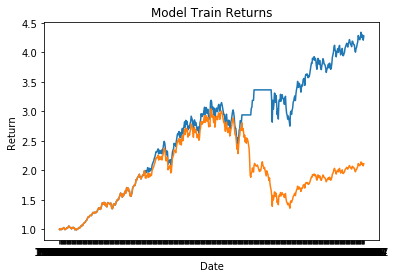

S&P return orange = 2.1097088438953895
ML return blue = 4.279534854456487




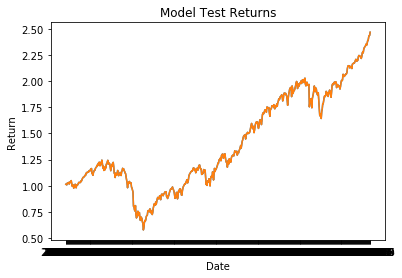

S&P return orange = 2.467675739217292
ML return blue = 2.467675739217292




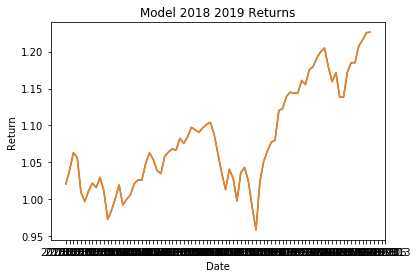

S&P return orange = 1.2262003830094492
ML return blue = 1.2262003830094492




Training Confusion Matrix
Predicted pos or neg return  False  True 
Actual pos or neg return                 
0                              104    157
1                               70    222
Accuracy Score of Training = 0.5895117540687161
Area under curve (AUC):  0.6302878811735685


Stock Return of Training Set = 2.1097088438953895
Stock Return of Training Set Preds Positive = 4.30002916845235
Stock Return of Training Set Preds Neg = 0.49062663559901076


Test Confusion Matrix
Predicted pos or neg return  False  True 
Actual pos or neg return                 
0                               50    201
1                               52    314
Accuracy Score of Test = 0.5899513776337115
Area under curve (AUC):  0.5523479851087454


Stock Return of Test Set = 2.467675739217292
Stock Return of Test Set Preds Positive = 2.775967292286644
Stock Return of Test Set Preds Neg = 0.8889426565197746


2018-2019 Conf

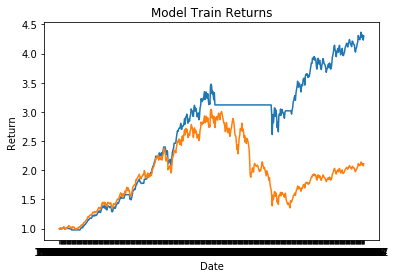

S&P return orange = 2.1097088438953895
ML return blue = 4.30002916845235




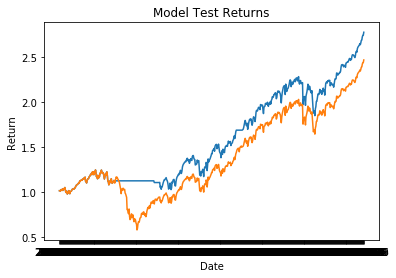

S&P return orange = 2.467675739217292
ML return blue = 2.775967292286644




In [ ]:
ml()

In [ ]:
df_ml.describe()

In [ ]:
ensemble(1)

In [ ]:
ensemble_dict()

blockprint()

## will take a while. 

for i in range(rounds):
    ensemble(0)

In [ ]:
enableprint()

In [ ]:
psuedo_cross_val_print(y)

In [ ]:
print("For " + str(rounds) + " rounds, the ensemble method outperforms on the out of sample data this many times: " \
      + str(sum(np.array(ensemble_test_pl_ml) > 2.467676)))

In [ ]:
print("For " + str(rounds) + " rounds, the ensemble method outperforms on the held back data this many times: " + \
      str(sum(np.array(ensemble_test_pl_ml_2) > 1.2262)))

In [ ]:
### Additional work after Dan's Review

In [ ]:
import statsmodels.api as sm
## train only
log = sm.Logit(Y_train,X_train)
results = log.fit()
results.summary()

In [ ]:
## full dataset
log = sm.Logit(df_ml['ml_ret'],df_ml[['z_78_sp','z_78_sp_median','z_78_t10','z_78_t10_median',\
                                     'z_78_t30','z_78_t30_median','momo_eem','momo_agg','rf']])
results = log.fit()
results.summary()

In [ ]:
### ensemble method 2:

In [ ]:
def ensemble_2(output):    
    global ensemble_train_pl_sp
    global ensemble_train_pl_ml
    global ensemble_test_pl_sp 
    global ensemble_test_pl_ml
    global ensemble_test_pl_sp_2 
    global ensemble_test_pl_ml_2
    global ensemble_accuracy_train
    global ensemble_accuracy_test
    global ensemble_accuracy_test_2
    global ensemble_std_train_ml
    global ensemble_std_train_sp
    global ensemble_std_test_ml
    global ensemble_std_test_sp
    global ensemble_std_test_2_ml
    global ensemble_std_test_2_sp
    
    
    #Train
    lg.fit(X_train,Y_train)
    preds_lg = lg.predict_proba(X_train)
    
    #10 time fit
    df_preds = pd.DataFrame()
    
    for i in range(10):
        gbc.fit(X_train,Y_train)
        clf.fit(X_train,Y_train)
        preds_gbc = gbc.predict_proba(X_train)
        preds_clf = clf.predict_proba(X_train)
        df_preds.insert(loc=0,column=str(i)+'preds_gbc',value=preds_gbc[:,1])
        df_preds.insert(loc=0,column=str(i)+'preds_clf',value=preds_clf[:,1])
    
    preds_ensemble = df_preds.median(axis=1).values
    preds_ensemble = (preds_ensemble + preds_lg[:,1]) / 2
    preds_ensemble = preds_ensemble > 0.5
    
    print("Ensemble Train Confusion Matrix")
    print(pd.crosstab(Y_train, preds_ensemble, rownames=['Actual pos or neg return'], colnames=['Predicted pos or neg return']))
    print("Accuracy Score of Train = " + accuracy_score(Y_train, preds_ensemble).astype(str))
    ensemble_accuracy_train.append(accuracy_score(Y_train, preds_ensemble))
    
    #P/L Chart Test
    preds = preds_ensemble
    pl = (train.stock_return * preds)
    
    #std dev calc
    std = (pl[pl != 0]).std()
    
    pl = pl.replace(to_replace=0,value=1)
    pl = pl.cumprod()
    
    if output == 1:
        plt.figure(0)
        title('Ensemble Train Returns')
        xlabel('Date')
        ylabel('Return')
        print('S&P return orange = ' + str(train.stock_return.cumprod()[-1]))
        print('ML return blue = '+str(pl[-1]))
        plot(pl)
        plot(train.stock_return.cumprod())
        plt.show()
    
    ## pseudo_cross_val append
    ensemble_train_pl_sp.append(train.stock_return.cumprod()[-1])
    ensemble_train_pl_ml.append(pl[-1])
    ensemble_std_train_ml.append(std)
    ensemble_std_train_sp.append(train.stock_return.std())
    
    #Test
    preds_lg = lg.predict_proba(X_test)
    
    #10 time fit
    df_preds = pd.DataFrame()
    
    for i in range(10):
        gbc.fit(X_train,Y_train)
        clf.fit(X_train,Y_train)
        preds_gbc = gbc.predict_proba(X_test)
        preds_clf = clf.predict_proba(X_test)
        df_preds.insert(loc=0,column=str(i)+'preds_gbc',value=preds_gbc[:,1])
        df_preds.insert(loc=0,column=str(i)+'preds_clf',value=preds_clf[:,1])
    
    preds_ensemble = df_preds.median(axis=1).values
    preds_ensemble = (preds_ensemble + preds_lg[:,1]) / 2
    preds_ensemble = preds_ensemble > 0.5
    
    print("Ensemble Test Confusion Matrix")
    print(pd.crosstab(Y_test, preds_ensemble, rownames=['Actual pos or neg return'], colnames=['Predicted pos or neg return']))
    print("Accuracy Score of Test = " + accuracy_score(Y_test, preds_ensemble).astype(str))
    ensemble_accuracy_test.append(accuracy_score(Y_test, preds_ensemble))
    
    #P/L Chart Test
    preds = preds_ensemble
    pl = (test.stock_return * preds)
    
    #std dev calc
    std = (pl[pl != 0]).std()
    
    pl = pl.replace(to_replace=0,value=1)
    pl = pl.cumprod()
    
    if output == 1:
        plt.figure(1)
        title('Ensemble Test Returns')
        xlabel('Date')
        ylabel('Return')
        print('S&P return orange = ' + str(test.stock_return.cumprod()[-1]))
        print('ML return blue = '+str(pl[-1]))
        plot(pl)
        plot(test.stock_return.cumprod())
        plt.show()
    
    ## pseudo_cross_val append
    ensemble_test_pl_sp.append(test.stock_return.cumprod()[-1])
    ensemble_test_pl_ml.append(pl[-1])
    ensemble_std_test_ml.append(std)
    ensemble_std_test_sp.append(test.stock_return.std())
    
    
    #Test 2018 - 2019
    preds_lg = lg.predict_proba(X_test_two)
    
    #10 time fit
    df_preds = pd.DataFrame()
    
    for i in range(10):
        gbc.fit(X_train,Y_train)
        clf.fit(X_train,Y_train)
        preds_gbc = gbc.predict_proba(X_test_two)
        preds_clf = clf.predict_proba(X_test_two)
        df_preds.insert(loc=0,column=str(i)+'preds_gbc',value=preds_gbc[:,1])
        df_preds.insert(loc=0,column=str(i)+'preds_clf',value=preds_clf[:,1])
    
    preds_ensemble = df_preds.median(axis=1).values
    preds_ensemble = (preds_ensemble + preds_lg[:,1]) / 2
    preds_ensemble = preds_ensemble > 0.5
    
    print("Ensemble Test 2018 2019 Confusion Matrix")
    print(pd.crosstab(Y_test_two, preds_ensemble, rownames=['Actual pos or neg return'], colnames=['Predicted pos or neg return']))
    print("Accuracy Score of Test = " + accuracy_score(Y_test_two, preds_ensemble).astype(str))
    ensemble_accuracy_test_2.append(accuracy_score(Y_test_two, preds_ensemble))
    
    #P/L Chart Test Two
    preds = preds_ensemble
    pl = (df_ml_test.stock_return * preds)
    
    #std dev calc
    std = (pl[pl != 0]).std()
    
    pl = pl.replace(to_replace=0,value=1)
    pl = pl.cumprod()
    
    if output == 1:
        plt.figure(2)
        title('Ensemble 2018 2019 Returns')
        xlabel('Date')
        ylabel('Return')
        print('S&P return orange = ' + str(df_ml_test.stock_return.cumprod()[-6]))
        print('ML return blue = '+str(pl[-6]))
        plot(pl)
        plot(df_ml_test.stock_return.cumprod())
        plt.show()
    
    ## pseudo_cross_val append
    ensemble_test_pl_sp_2.append(df_ml_test.stock_return.cumprod()[-6]) 
    ensemble_test_pl_ml_2.append(pl[-6])
    ensemble_std_test_2_ml.append(std)
    ensemble_std_test_2_sp.append(df_ml_test.stock_return.std())

In [ ]:
ensemble_2(1)

In [ ]:
ensemble_dict()

blockprint()

## will take a while. 

for i in range(rounds):
    ensemble_2(0)

In [ ]:
enableprint()

In [ ]:
psuedo_cross_val_print(y)

In [ ]:
print("For " + str(rounds) + " rounds, the ensemble 2.0 method outperforms on the out of sample data this many times: " \
      + str(sum(np.array(ensemble_test_pl_ml) > 2.467676)))

In [ ]:
print("For " + str(rounds) + " rounds, the ensemble 2.0 method outperforms on the held back data this many times: " + \
      str(sum(np.array(ensemble_test_pl_ml_2) > 1.2262)))